# Follow-up

This tab provides an overview of the clinical trial status, ie. number of patients, median follow-up times, total data, missing data, etc.

In [1]:
import sys
sys.path.append("C:\\Users\\Fabien Boux\\Code\\ClinLib")

from clinlib.database import Database
database = Database("C:\\Users\\Fabien Boux\\Code\\Oncology-clinical-trial\\data\\dummy", idlength=3)
database.add_resource({'metadata': "C:\\Users\\Fabien Boux\\Code\\Oncology-clinical-trial\\data\\dummy\\metadata.xlsx"})

from functions.config import Config
config = Config()
config.read()

In [2]:
import pandas as pd
import numpy as np

metadata = database.get_metadata(which='all')

group = metadata['Group']
group_labels = group.unique()

df = pd.DataFrame([], columns=list(group_labels) + ['Overall'])

df.loc['Number of patients'] = [(metadata['Group'] == g).sum() for g in group_labels] + [len(metadata['Group'])]
df.loc['Median follow-up (days)'] = [(metadata['End'][metadata['Group'] == g] - metadata['Start'][metadata['Group'] == g]).median().days for g in group_labels] + [(metadata['End'] - metadata['Start']).median().days]

df

,0,1,Overall
Number of patients,97,103,200
Median follow-up (days),351,371,358


The following plot is a *swimmer plot*. This graph allows a fast overview of all data, it combines time to event (patient's treatment, death or end of the follow-up) and imaging (via lesion evolutions if available).
Note that some variables used in this graph can be defined in the ```Configuration``` tab (the follow-up time, list of potential vist sessions, ...).

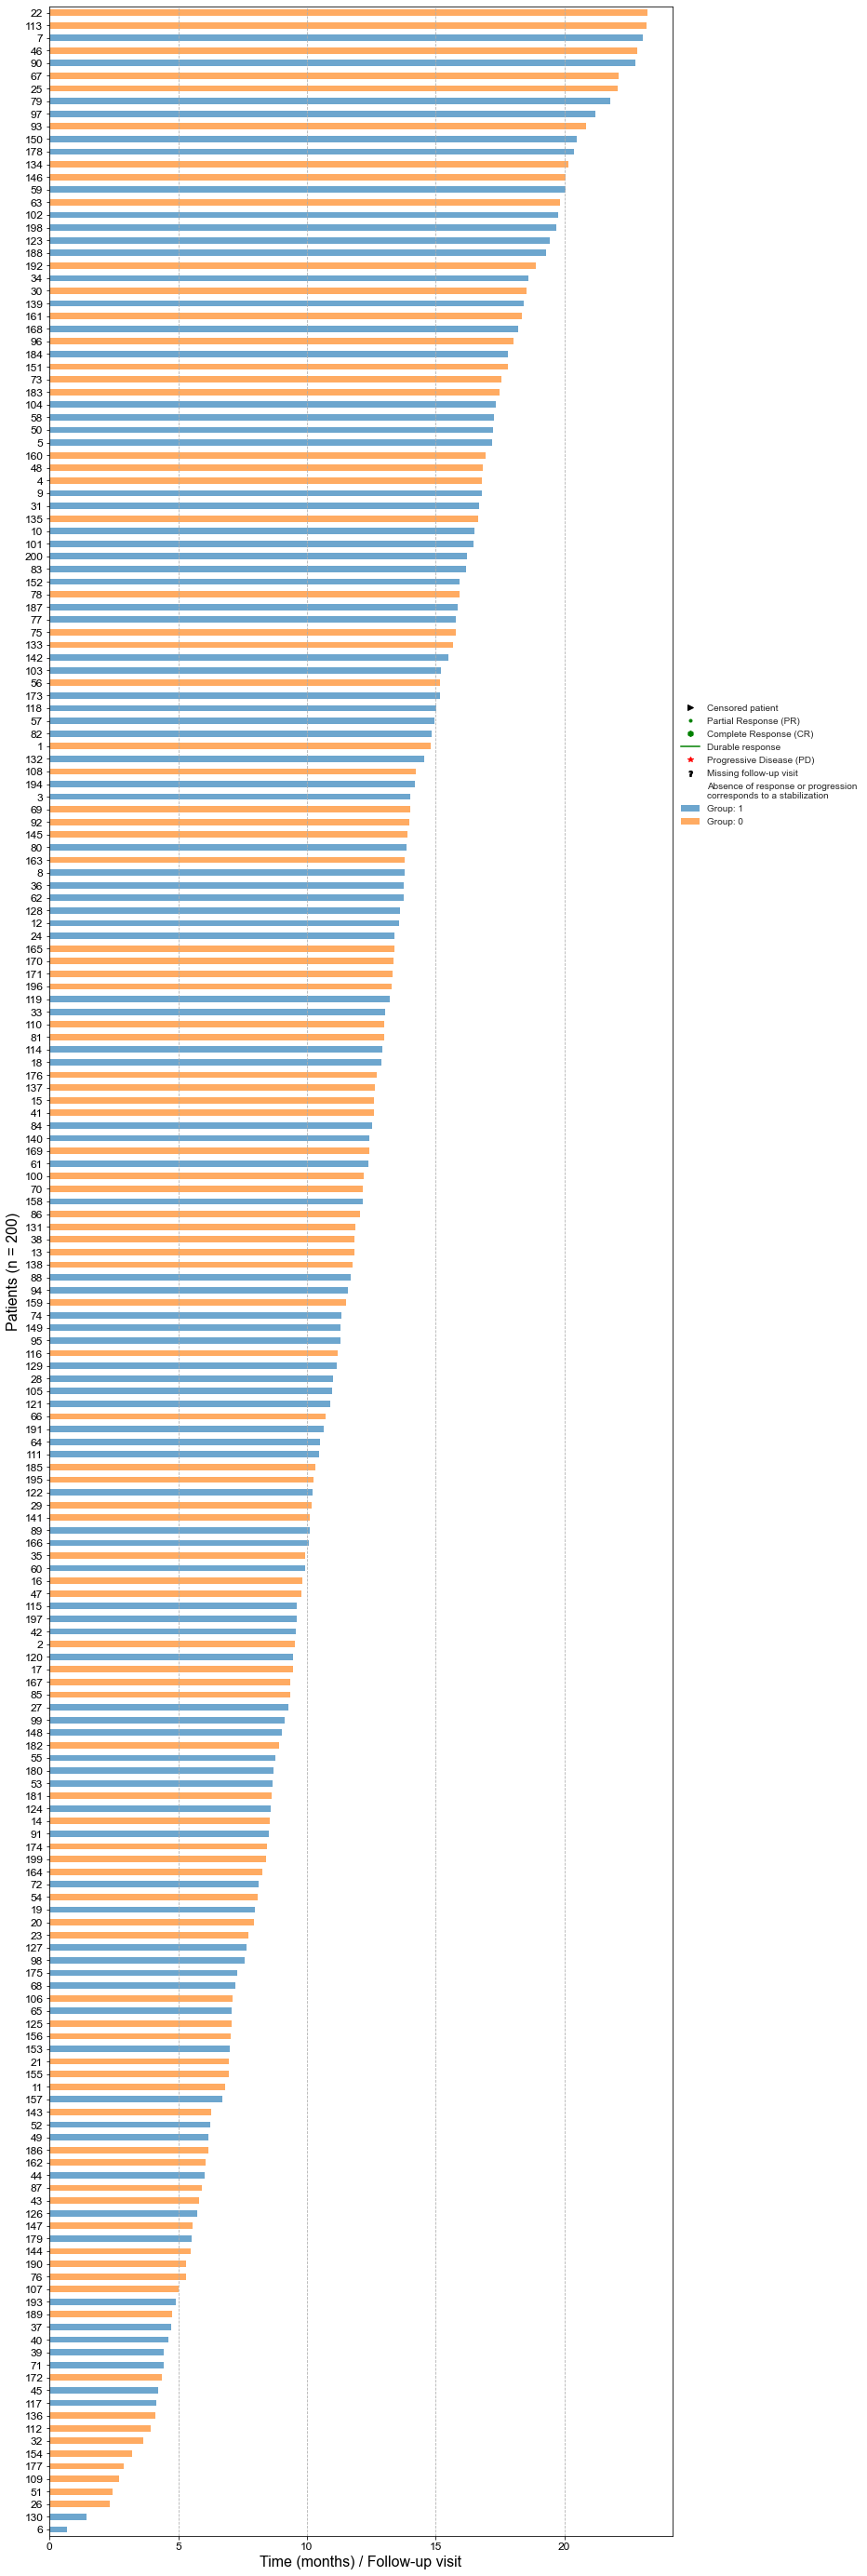

In [3]:
from functions.graph import swimmer_plot

if config.is_key('followup_time'):
    followup_time = config.get_value('followup_time')
else:
    followup_time = 24
if config.is_key('followup_visits'):
    followup_visits = config.get_value('followup_visits')
else:
    followup_visits = None

swimmer_plot(database, followup_time=followup_time, followup_visits=followup_visits);